In [1]:
import datamodule
import h5torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import torchmetrics as m

In [2]:
# Fix for: You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
torch.set_float32_matmul_precision('high')

## Load Data

In [3]:
dataset = h5torch.Dataset("GNPS.h5t")

In [4]:
batch_size = 128

data = datamodule.GNPSDataModule("GNPS.h5t", batch_size)
data.setup(0)

In [85]:
def bin_spectrum(mzs, intensities):
    return (
        np.histogram(mzs, np.arange(10, 1_000 + 1e-8, 1), weights=intensities)[0]
    )


def sample_processor(f, sample):
    return {
        "fingerprint" : sample['0/fingerprint'],
        "spectrum" : bin_spectrum(sample['0/mzs'], sample['0/intensities']),
    }

data = h5torch.Dataset(
    "GNPS.h5t",
    sample_processor=sample_processor,
)

In [95]:
#i = iter(data)
next(i)

{'fingerprint': array([0, 0, 0, ..., 0, 0, 0]),
 'spectrum': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 

## Plot Spectrum

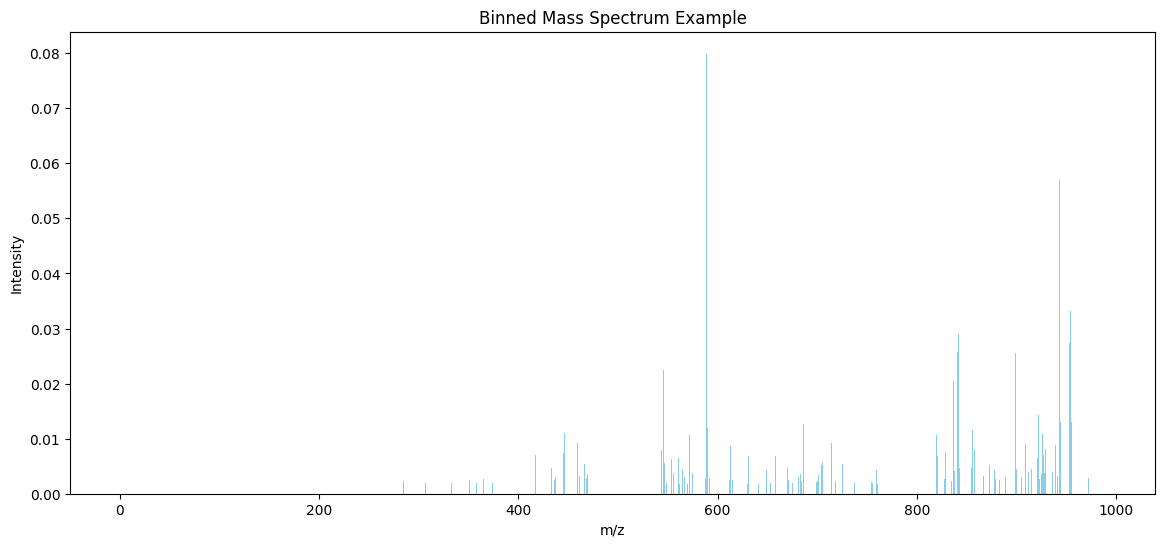

In [105]:
#torch.set_printoptions(profile="full")
#spectrum = next(iter(data.train_dataloader()))['spectrum'][1]
spectrum = next(iter(data))['spectrum']

# Plotting the spectrum as a bar plot
plt.figure(figsize=(14, 6))
plt.bar(range(len(spectrum)), list(spectrum), color='skyblue')
plt.xlabel('m/z')
plt.ylabel('Intensity')
#plt.ylim(0, 0.6)
plt.title('Binned Mass Spectrum Example')
plt.show()

In [61]:
spectrum

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0052, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0299, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0105, 0.0000, 0.0019, 

## Check Fingerprint distribution

In [81]:
fingerprint_sum = torch.zeros(4096)

for x in data:
    fingerprint_sum += x['fingerprint'].sum(axis=0)

fingerprint_sum /= len(data.train_dataloader()) * batch_size

KeyboardInterrupt: 

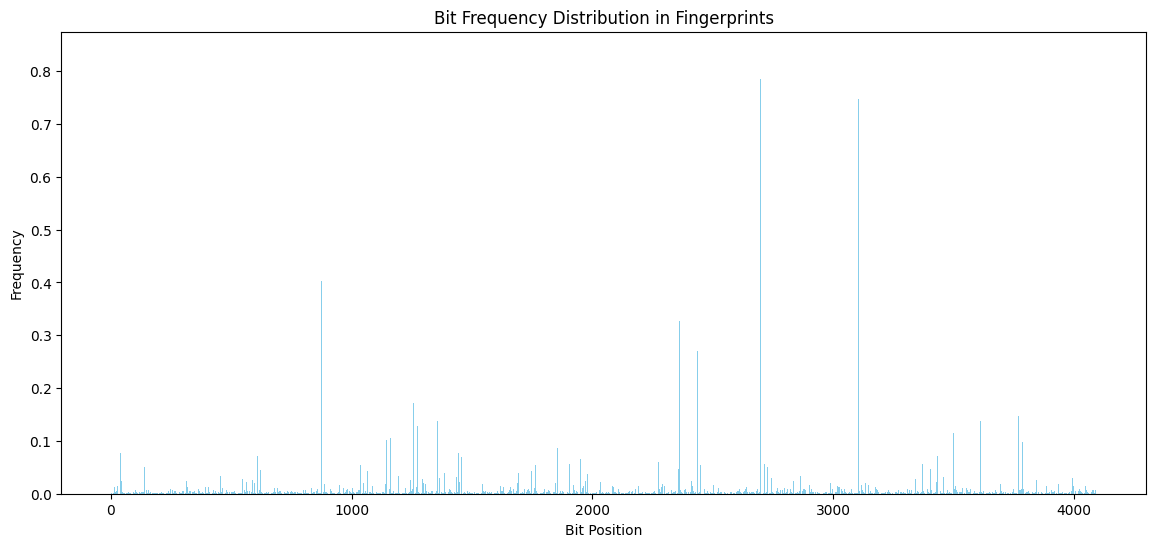

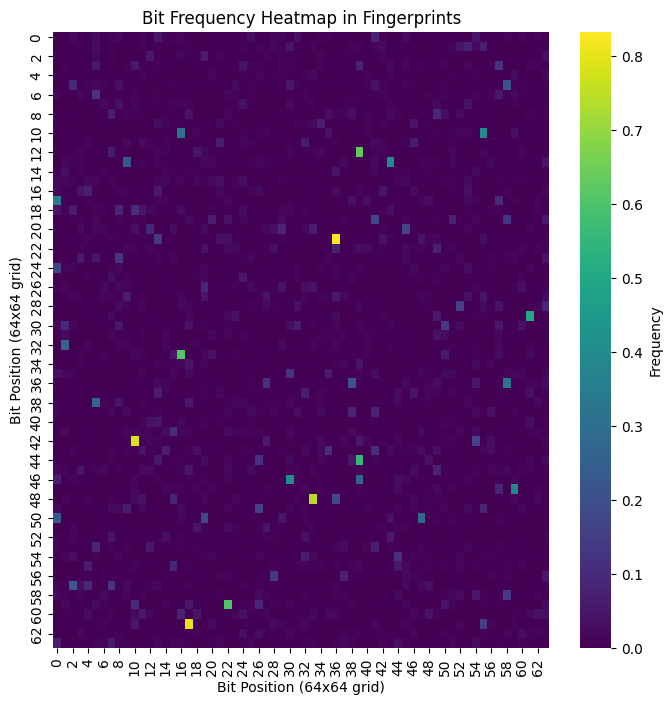

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


frequency_vector = fingerprint_sum  

# Plotting the frequency distribution as a bar plot
plt.figure(figsize=(14, 6))
plt.bar(range(len(frequency_vector)), frequency_vector, color='skyblue')
plt.xlabel('Bit Position')
plt.ylabel('Frequency')
plt.title('Bit Frequency Distribution in Fingerprints')
plt.show()

# Plotting the frequency distribution as a heatmap for a more compact view
# Reshape the vector to a 64x64 grid for visualization (as 4096 = 64x64)
frequency_matrix = frequency_vector.reshape((64, 64))

plt.figure(figsize=(8, 8))
sns.heatmap(frequency_matrix, cmap='viridis', cbar_kws={'label': 'Frequency'})
plt.title('Bit Frequency Heatmap in Fingerprints')
plt.xlabel('Bit Position (64x64 grid)')
plt.ylabel('Bit Position (64x64 grid)')
plt.show()


## Train Model

In [ ]:
# LightningModule that receives a PyTorch model as input
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
    
        self.accuracy = m.Accuracy(task="multilabel", num_labels=model.output_size)
        self.precision = m.Precision(task="multilabel", num_labels=model.output_size)
        self.recall = m.Recall(task="multilabel", num_labels=model.output_size)
        self.f1score = m.F1Score(task="multilabel", num_labels=model.output_size)
        self.jaccard = m.JaccardIndex(task="multilabel", num_labels=model.output_size)
        self.dice = m.Dice()
        #self.cosine_sim = m.CosineSimilarity(reduction = 'mean')

    def forward(self, x):
        return self.model(x)
        
    def calculate_metrics(self, batch, prefix=''):
        X = batch['spectrum']
        Y = batch['fingerprint'].float()
        
        logits = self(X)
        
        # calculate loss (Try different loss functions)
        loss = F.binary_cross_entropy_with_logits(logits, Y)
        
        # Apply sigmoid to get probabilities
        predicted_probs = F.sigmoid(logits)
        # Convert probabilities to binary predictions (threshold = 0.5)
        predicted_labels = (predicted_probs > 0.5)
        
        accuracy = self.accuracy(predicted_labels, Y)
        precision = self.precision(predicted_labels, Y)
        recall = self.recall(predicted_labels, Y)
        f1score = self.f1score(predicted_labels, Y)
        jaccard = self.jaccard(predicted_labels, Y.int())
        dice = self.dice(logits, Y.int())
        #cosine_sim = self.cosine_sim(logits, Y)
        
        return {
            prefix+'loss': loss,
            prefix+'accuracy': accuracy,
            prefix+'precision': precision,
            prefix+'recall': recall,
            prefix+'f1score': f1score,
            prefix+'jaccardIndex': jaccard,
            prefix+'dice': dice,
            #prefix+'cosine_sim': cosine_sim
        }
        
    
    def training_step(self, batch, batch_idx):
        metrics = self.calculate_metrics(batch, prefix='train_')
        self.log_dict(metrics)
        return metrics['train_loss']  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        metrics = self.calculate_metrics(batch, prefix='val_')
        self.log_dict(metrics, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        metrics = self.calculate_metrics(batch, prefix='test_')
        self.log_dict(metrics, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [ ]:
class myMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[]):
        super().__init__()

        self.output_size = output_size
        
        # init layers (default Linear + Relu)
        layers = [input_size] + hidden_sizes + [output_size]
        l = []
        for i in range(len(layers)-1):
            l.append(nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                l.append(nn.ReLU())
            else:
                break
                
        self.layers = torch.nn.Sequential(*l)

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [ ]:
train_loader = data.train_dataloader()
val_loader = data.val_dataloader()

# Assuming DataLoader train_loader is provided, and has input_size and output_size
input_size = train_loader.dataset[0]['spectrum'].shape[0]  # Assuming first element gives the shape
output_size = train_loader.dataset[0]['fingerprint'].shape[0]  # Assuming labels are bitvectors

MLP_archs = [[2048, 8192]]#, [8192, 2048], [2048, 2048]]#[2048, 4096, 8192]
EPOCHS = 50
LRs = [.005]#[.05, .01, .005]
model_name = "MLP_loss_func_test"

for hs in MLP_archs:
    for LR in LRs:
        print(hs, LR)
        pytorch_model = myMLP(input_size, output_size, hs)
        lightning_model = LightningModel(model=pytorch_model, learning_rate=LR)
        logger = L.pytorch.loggers.TensorBoardLogger("lightning_logs", name=model_name, version=f"H{hs}LR{LR:.0e}E{EPOCHS}")

        trainer = L.Trainer(
            max_epochs=EPOCHS,
            accelerator="gpu",  # set to "auto" or "gpu" to use GPUs if available
            devices="auto",  # Uses all available GPUs if applicable
            logger=logger
        )

        trainer.fit(
            model=lightning_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader,
        )

[2048, 8192] 0.005


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-11-01 15:01:09.021568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 15:01:09.525807: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-11-01 15:01:09.525934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-11-01 15:01:09.525943: W tensorflow/compiler/

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/wwelvaer/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Exception in thread Thread-10 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wwelvaer/.local/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 53, in _pin_memory_loop
    do_one_step()
  File "/home/wwelvaer/.local/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 30, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/wwelvaer/.local/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 495, in rebuild_storage_fd
    fd 

In [3]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/MLP1 --port 6009

In [60]:
test_set = data.test
trainer.test(lightning_model, dataloaders=torch.utils.data.DataLoader(test_set, num_workers=4))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9946997165679932
      test_f1score          0.6086375713348389
        test_loss          0.024547751992940903
     test_precision         0.6675792336463928
       test_recall          0.5863217115402222
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.024547751992940903,
  'test_accuracy': 0.9946997165679932,
  'test_precision': 0.6675792336463928,
  'test_recall': 0.5863217115402222,
  'test_f1score': 0.6086375713348389}]